In [14]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np


import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.9.1')
#pyro.set_rng_seed(1)
torch.set_default_tensor_type(torch.DoubleTensor)

import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch

from sklearn import model_selection
import pyro.contrib.gp as gp

import torch
import numpy as np
import seaborn as sns
import arviz as az  

def kernel(X, Z, variance, lengthscale):
    calc = variance.pow(2) * torch.exp(-(1 / 2 * lengthscale.pow(2)) * (X - Z).pow(2))
    return calc
kernel2 = gp.kernels.RBF(input_dim=1, variance=torch.tensor(4.01), lengthscale=torch.tensor(0.1))

q = 2 
def func(x):
    return - np.power((np.sin(6*np.pi*x)),2) + 6*np.power(x,2) - 5*np.power(x,4) + (3/2)
x= np.linspace(0,1,100)

y = func(x)

def datafunc(x):
    return func(x) + np.random.normal(0,0.01)
    
def gendata(l):
    x = np.array(range(0,l-1))/(l-1)
    y = datafunc(x)   
    return x,y
    
data  = gendata(101)
X, y = data[0], data[1]
#plt.scatter(X, y)
#plt.plot(x,y)
#plt.show()
print ("Area less than q", np.sum(y)/100 <q )


w = [1/(100-1) for i in range(100)]
w[0] = 1/(200-2)
w[-1] = 1/(200-2)
w = torch.tensor(np.array(w))

D = np.array([(0, 1.46), (0.25, 0.93), (0.5, 2.76)])
for q in [0, 2 ,5,10]:
    
    K = kernel2(torch.tensor(X), torch.tensor(X))
    S_11 = w @ K @ w
    S_21 = K @ w 
    S_12 = w @ K
    S_22 = K

    
    mean = S_21 * (1/S_11) * q
    covariance = S_22 - (S_21.unsqueeze(1) @ ((1/S_11) * S_21).unsqueeze(0)) + torch.eye(X.shape[0]) * 0.0001
    scale_tril = torch.linalg.cholesky(covariance)


    distrobution = dist.MultivariateNormal(mean, scale_tril=scale_tril)

    samples = distrobution.sample(torch.Size([5]))

    print(samples.shape[0])

    #sns.jointplot(
    #x= X,
    #y= samples[0],
    #kind="kde",
    #fill=True,
    #cmap="Blues")
    plt.scatter(X, samples[0])
    plt.scatter(X, samples[1])
    plt.scatter(X, samples[2])
    plt.scatter(X, samples[3])
    plt.scatter(X, samples[4])
    #sns.displot(samples[1], bins = 20)
    plt.show()
    



Area less than q True


_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 1 is not positive-definite).

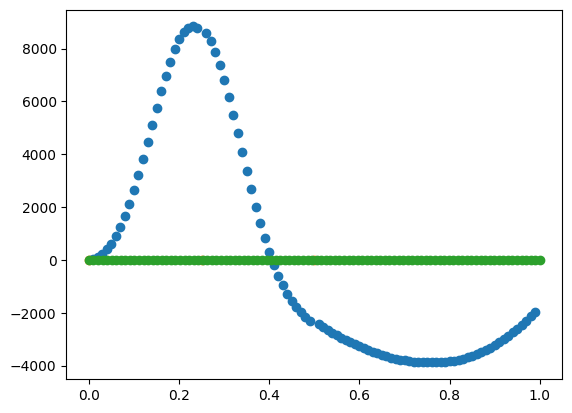

In [4]:
excluded_indices = {0, 25, 50}
mask = ~np.isin(np.arange(mean.shape[0]), list(excluded_indices))
plt.scatter(X[mask], post_mean.detach().numpy())
plt.scatter(D[:,0], D[:, 1])
plt.scatter(x, y)

In [4]:
def posterior_prediction(X, Y):
    #Calculate old MU and old COVARIANCE
    K = kernel2(torch.tensor(X), torch.tensor(X))
    q = 2
    S_11 = w @ K @ w
    S_21 = K @ w 
    S_12 = w @ K
    S_22 = K

    
    mean = S_21 * (1/S_11) * q
    covariance = S_22 - (S_21.unsqueeze(1) @ ((1/S_11) * S_21).unsqueeze(0)) + torch.eye(X.shape[0]) * 0.0001

    excluded_indices = {0, 25, 50}
    mean_original = mean[~np.isin(np.arange(len(mean)), list(excluded_indices))]
    
    
    mask = ~np.isin(np.arange(mean.shape[0]), list(excluded_indices))
    covariance_original = covariance[mask][:, mask]

    
    #INDEX ROWS FROM Y TO ALL and Y to Y
    excluded_indices = [0, 25, 50]
    helper = covariance[:, excluded_indices]
    y_to_all = helper[3:,:]
    y_to_y = helper[:3,:]

    noise = torch.rand(3) * 0.01
    diagonal_tensor = torch.diag(noise)

    post_mean =  mean_original + torch.tensor(y_to_all) @ torch.tensor((1/(y_to_y+diagonal_tensor))) @ torch.sub(torch.tensor(D[:,1]), mean[excluded_indices]) 
    post_cov = covariance_original - torch.tensor(y_to_all) @ torch.tensor((1/(y_to_y+diagonal_tensor))) @ torch.tensor(y_to_all).T
    
    print(post_mean.shape)
    print(post_cov.shape)
    return post_mean, post_cov

In [5]:
excluded_indices = [0, 25, 50]
y[excluded_indices]

array([1.49409801, 0.84956676, 2.68159801])